# Solving non-linear coupled reaction-difusion problem

## Problem Description
$$ \frac{∂u}{∂t} = D_u \Delta u + k (a-u+u^2 v)  \tag{1} $$
$$ \frac{\partial v}{\partial t} = D_v \Delta v + k(b-u^2 v)  \tag{2}$$
$$ (x,y) \in \Omega, t \in (0, T]  \tag{3}$$
$$ u(x,y,0)=u_0(x,y), v(x,y,0) = v_0(x,y), (x,y) \in \Omega \tag{4} $$
$$ -D_u \nabla u \cdot n = 0, -D_v \nabla v \cdot n = 0, (x,y) \in \partial \Omega \tag{5}$$
$$ D_u = 0.05, D_v = 1.0, k = 5, a = 0.1305, b = 0.7695 \tag{6}$$
$$ u_0(x,y) = a+b+r(x,y), v_0(x,y) = \frac{b}{(a+b)^2} \tag{7}$$ 
$$ \Omega = (0,4) \times (0,4), T = 20 \tag{8} $$


Import packages and define global variables:

In [1]:
using LinearAlgebra
using Plots
using DifferentialEquations
using SparseArrays
using BenchmarkTools

Nx = Ny = 100           # number of integrals
Du, Dv = 0.05, 1.0      # difffusivity constants
k, a, b = 5, 0.1305, 0.7695 # reaction sonstants
FT = Float64;           #Float type
Lx = Ly = 4             # domain size
T = 20.0                # ending time
dx = FT(Lx)/FT(Nx) 
dy = FT(Ly)/FT(Ny)
h = dx = dy

0.04

In [2]:
function compute_u0(a, b, Nx, Ny) # equation (7)
    return a + b .+ 0.01 * (a + b) * rand((Nx - 1) * (Ny - 1))
end

function compute_v0(a, b, Nx, Ny)
    return fill(b / ((a + b)^2), (Nx - 1) * (Ny - 1))
end


@code_warntype compute_u0(a, b, Nx, Ny)
@code_warntype compute_v0(a, b, Nx, Ny)

MethodInstance for compute_u0(::Float64, ::Float64, ::Int64, ::Int64)
  from compute_u0(a, b, Nx, Ny) @ Main c:\Users\Admin\Desktop\Pattern-formation-in-sediment-transport-in-rivers\jupyter notebook\coupled-diffusion.ipynb:1


Arguments
  

#self#::Core.Const(compute_u0)
  a::Float64
  b::Float64
  Nx::Int64
  Ny::Int64
Body::Vector{Float64}


1 ─ %1  = Main.:

+::Core.Const(+)
│   %2  

= (a + b)::Float64
│   %3  = (a + b)::Float64
│   %4  = (Nx - 1)::Int64
│   %

5  = (Ny - 1)::Int64
│   %6  = (%4 * %5)::Int64
│   %

7  = Main.rand(%6)::Vector{Float64}
│   %8  = (0.01 * %3 * %7)::Vector{Float64}
│  

 %9  = Base.broadcasted(%1, %2, %8)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(+), Tuple{Float64, Vector{Float64}}}
│   %10 = Base.materialize(%9)::Vector{Float64}
└──       return %10

MethodInstance for compute_v0(::Float64, ::Float64, ::Int64, ::Int64)
  from compute_v0(a, b, Nx, Ny) @ Main c:\Users\Admin\Desktop\Pattern-formation-in-sediment-transport-in-rivers\jupyter notebook\coupled-diffusion.ipynb:5
Arguments
  #self#::Core.Const(compute_v0)
  a::Float64


  b::Float64
  Nx::Int64
  Ny::Int64
Body::Vector{Float64}
1 ─ %1  = Main.:^::Core.Const(^)
│   %2  = (a + b)::Float64
│   %3  = Core.apply_type(Base.Val, 2)::Core.Const(Val{2})
│   %4  

= (%3)()::Core.Const(Val{2}())
│   %5  = Base.literal_pow(%1, %2, %4)::Float64
│   %6  = (b / %5)::Float64
│   %7  = (Nx - 1)::Int64
│   %8  = (Ny - 1)::Int64
│   %9  = (%7 * %8)::Int64
│   

%10 = Main.fill(%6, %9)::Vector{Float64}
└──       return %10



In [8]:
function FDLaplacian2D(Nx::Int64, Ny::Int64, dx::FT, dy::FT)
    Dx = zeros(Nx, Nx-1)
    Dx[1:Nx+1:end] .= 1   # construct diagonals
    Dx[2:Nx+1:end] .= -1  
    Dx *= 1/dx  
    Dx[1, :] .= 0  # add boundary conditions
    Dx[end, :] .= 0


    Dy = zeros(Ny, Ny-1)
    Dy[1:Ny+1:end] .= 1     # construct diagonals
    Dy[2:Ny+1:end] .= 1
    Dy *= 1/dy
    Dy[1, :] .= 0   # add boundary conditions
    Dy[end, :] .= 0

    Lxx = transpose(Dx) * Dx
    Lyy = transpose(Dy) * Dy

    Ix = I(Nx-1)
    Iy = I(Ny-1)

    A = kron(Iy, Lxx) + kron(Lyy, Ix)
    return A
end

# @btime A = FDLaplacian2D()

@code_warntype FDLaplacian2D(Nx, Ny, dx, dy)

MethodInstance for FDLaplacian2D(::Int64, ::Int64, ::Float64, ::Float64)
  from FDLaplacian2D(Nx::Int64, Ny::Int64, dx::Float64, dy::Float64) @ Main c:\Users\Admin\Desktop\Pattern-formation-in-sediment-transport-in-rivers\jupyter notebook\coupled-diffusion.ipynb:1
Arguments
  #self#::Core.Const(FDLaplacian2D)
  Nx

::Int64
  Ny::Int64
  dx::Float64
  dy::Float64
Locals
  A::Matrix{Float64}
  Iy::Diagonal{Bool, Vector{Bool}}
  Ix::Diagonal{Bool, Vector{Bool}}
  Lyy::Matrix{Float64}
  Lxx::Matrix{Float64}
  Dy::Matrix{Float64}
  Dx::Matrix{Float64}
Body::Matrix{Float64}
1 ─ %1  = (Nx - 1)::Int64
│         (Dx = Main.zeros(Nx, %1))
│   %3  = Dx::Matrix{Float64}
│   %4  = (Nx + 1

)::Int64
│   %5  = Base.lastindex(Dx)::Int64
│   %6  = (1:%4:%5)::Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(1), Int64, Int64])
│   %7  = Base.dotview(%3, %6)::Core.PartialStruct(SubArray{Float64, 1, Vector{Float64}, Tuple{StepRange{Int64, Int64}}, true}, Any[Vector{Float64}, Core.PartialStruct(Tuple{StepRange{Int64, Int64}}, Any[Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(1), Int64, Int64])]), Int64, Int64])
│   %8  = Base.broadcasted(Base.identity, 1)::Core.Const(Base.Broadcast.Broadcasted(identity, (1,)))
│         Base.materialize!(%7, %8)
│   %10 = Dx::Matrix{Float64}
│  

 %11 = (Nx + 1)::Int64
│   %12 = Base.lastindex(Dx)::Int64
│   %13 = (2:%11:%12)::Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(2), Int64, Int64])
│   %14 = Base.dotview(%10, %13)::Core.PartialStruct(SubArray{Float64, 1, Vector{Float64}, Tuple{StepRange{Int64, Int64}}, true}, Any[Vector{Float64}, Core.PartialStruct(Tuple{StepRange{Int64, Int64}}, Any[Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(2), Int64, Int64])]), Int64, Int64])
│   %15 = Base.broadcasted(Base.identity, -1)::Core.Const(Base.Broadcast.Broadcasted(identity, (-1,)))
│         Base.materialize!(%14, %15)
│   %17 = Dx::Matrix{Float64}
│   %18 = (1 / dx)::Float64
│         (Dx = %17 * %18)
│   %20 = Base.dotview(Dx, 1, Main.:(:))::Core.PartialStruct(SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Any[Matrix{Float64}, Core.PartialStruct(Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, Any[Core.Const(1), Base.Slice{Base.OneTo{Int64}}]), Int64, Int64])
│   %21 =

0)::Core.Const(Base.Broadcast.Broadcasted(identity, (0,)))
│         Base.materialize!(%20, %21)
│   %23 = Dx::Matrix{Float64}
│   %24 = Base.lastindex(Dx, 1)::Int64
│   %25 = Base.dotview(%23, %24, Main.:(:))::SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}
│   %26 = Base.broadcasted(Base.identity, 0)::Core.Const(Base.Broadcast.Broadcasted(identity, (0,)))
│         Base.materialize!(%25, %26)
│   %28 = (Ny - 1)::Int64
│         (Dy = Main.zeros(Ny, %28))
│   

%30 = Dy::Matrix{Float64}
│   %31 = (Ny + 1)::Int64
│   %32 = Base.lastindex(Dy)::Int64
│   %33 = (1:%31:%32)::Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(1), Int64, Int64])
│   %34 = Base.dotview(%30, %33)::Core.PartialStruct(SubArray{Float64, 1, Vector{Float64}, Tuple{StepRange{Int64, Int64}}, true}, Any[Vector{Float64}, Core.PartialStruct(Tuple{StepRange{Int64, Int64}}, Any[Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(1), Int64, Int64])]), Int64, Int64])
│   %35 = Base.broadcasted(Base.identity, 1)::Core.Const(Base.Broadcast.Broadcasted(identity, (1,)))
│         Base.materialize!(%34, %35)
│   %37 = Dy::Matrix{Float64}
│   %38 = (Ny + 1)::Int64
│   

%39 = Base.lastindex(Dy)::Int64
│   %40 = (2:%38:%39)::Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(2), Int64, Int64])
│   %41 = Base.dotview(%37, %40)::Core.PartialStruct(SubArray{Float64, 1, Vector{Float64}, Tuple{StepRange{Int64, Int64}}, true}, Any[Vector{Float64}, Core.PartialStruct(Tuple{StepRange{Int64, Int64}}, Any[Core.PartialStruct(StepRange{Int64, Int64}, Any[Core.Const(2), Int64, Int64])]), Int64, Int64])
│   %42 = Base.broadcasted(Base.identity, 1)::Core.Const(Base.Broadcast.Broadcasted(identity, (1,)))
│         Base.materialize!(%41, %42)
│   %44 = Dy::Matrix{Float64}
│   %45 = (1 / dy)::Float64
│         

(Dy = %44 * %45)
│   %47 = Base.dotview(Dy, 1, Main.:(:))::Core.PartialStruct(SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Any[Matrix{Float64}, Core.PartialStruct(Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, Any[Core.Const(1), Base.Slice{Base.OneTo{Int64}}]), Int64, Int64])
│   %48 = Base.broadcasted(Base.identity, 0)::Core.Const(Base.Broadcast.Broadcasted(identity, (0,)))
│         Base.materialize!(%47, %48)
│   %50 = Dy::Matrix{Float64}
│   %51 = Base.lastindex(Dy, 1)::Int64
│   %52 = Base.dotview(%50, %51, Main.:(:)

)::SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}
│   %53 = Base.broadcasted(Base.identity, 0)::Core.Const(Base.Broadcast.Broadcasted(identity, (0,)))
│         Base.materialize!(%52, %53)
│   %55 = Main.transpose(Dx)::Transpose{Float64, Matrix{Float64}}
│         (Lxx = %55 * Dx)
│   %57 = Main.transpose(Dy)::Transpose{Float64, Matrix{Float64}}
│         (Lyy = %57 * Dy)
│   %59 = (Nx - 1)::Int64
│         (Ix = Main.I(%59))
│   %61 = (Ny - 1)::Int64
│         (Iy = Main.I(%61))
│   %63 = Main

.kron(Iy, Lxx)::Matrix{Float64}
│   %64 = Main.kron(Lyy, Ix)::Matrix{Float64}
│         (A = %63 + %64)
└──       return A



MethodInstance for Core.kwcall(::NamedTuple{(:save_everystep,), Tuple{Bool}}, ::typeof(solve), ::ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, NamedTuple{(:Du, :Dv, :A, :k, :a, :b), Tuple{Float64, Float64, Matrix{Float64}, Int64, Float64, Float64}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(RHS!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem})
  from kwcall(::Any, ::typeof(solve), prob::SciMLBase.AbstractDEProblem, args...) @ DiffEqBase C:\Users\Admin\.julia\packages\DiffEqBase\xSmHR\src\solve.jl:933
Arguments
  _::Core.Const(Core.kwcall)
  @_2::NamedTuple{(:save_everystep,), Tuple{Bool}}
  @_3::Core.Const(CommonSolve.solve)
  prob::ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, NamedTuple{(:Du, :Dv, :A, :k

       Core.NewvarNode(:(sensealg))
│         Core.NewvarNode(:(u0))
│         Core.NewvarNode(:(p))
│         Core.NewvarNode(:(wrap))
│         Core.NewvarNode(:(kwargs...))
│         Core.NewvarNode(:(@_11))
│   %7  = Core.isdefined(@_2, :sensealg)::Core.Const(false)
└──       goto #3 if not %7
2 ─       Core.Const(:(@_11 = Core.getfield(@_2, :sensealg)))
└──       Core.Const(:(goto %

12))
3 ┄       (@_11 = DiffEqBase.nothing)
│   %12 = @_11::Core.Const(nothing)
│   %13 = Core.isdefined(@_2, :u0)::Core.Const(false)
└──

       goto #5 if not %13
4 ─       Core.Const(:(@_11 = Core.getfield(@_2, :u0)))
└──

       Core.Const(:(goto %18))
5 ┄       (@_11 = DiffEqBase.nothing)
│   %18 = @_11::Core.Const(nothing)
│   %19 = Core.isdefined(@_2, :p)::Core.Const(false)
└──       goto #7 if not %19
6 ─       Core.Const(:(@_11 = Core.getfield(@_2, :p)))
└──       Core.Const(:(goto %24))
7 ┄       (@_11 = DiffEqBase.nothing)
│   %24 = @_11::Core.Const(nothing)
│   %25 = Core.isdefined(@_2, :wrap)::Core.Const(false)
└──

       goto #9 if not %25
8 ─       Core.Const(:(@_11 = Core.getfield(@_2, :wrap)))
└──       Core.Const(:(goto %30))
9 ┄       (@_11 = DiffEqBase.Val(true))
│   %30 = @_11::Core.Const(Val{true}())
│   %31 = (:sensealg, :u0, :p, :wrap)::Core.Const((:sensealg, :u0, :p, :wrap))
│   %32 = Core.apply_type(Core.NamedTuple, %31)::Core.Const(NamedTuple{(:sensealg, :u0, :p, :wrap)})
│   %33 = Base.structdiff(@_2, %32)::NamedTuple{(:save_everystep,), Tuple{Bool}}
│         (kwargs...

 = Base.pairs(%33))
│   %35 = DiffEqBase.:(var"#solve#40")::Core.Const(DiffEqBase.var"#solve#40")
│   %36 = Core.tuple(%12, %18, %24, %30, kwargs...::Core.PartialStruct(Base.Pairs{Symbol, Bool, Tuple{Symbol}, NamedTuple{(:save_everystep,), Tuple{Bool}}}, Any[NamedTuple{(:save_everystep,), Tuple{Bool}}, Core.Const((:save_everystep,))]), @_3, prob)::Core.PartialStruct(Tuple{Nothing, Nothing, Nothing, Val{true}, Base.Pairs{Symbol, Bool, Tuple{Symbol}, NamedTuple{(:save_everystep,), Tuple{Bool}}}, typeof(solve), ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, NamedTuple{(:Du, :Dv, :A, :k, :a, :b), Tuple{Float64, Float64, Matrix{Float64}, Int64, Float64, Float64}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(RHS!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


  609.073 ms (320 allocations: 5.93 MiB)


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Admin\.julia\packages\SciMLBase\ZUwcW\src\integrator_interface.jl:606


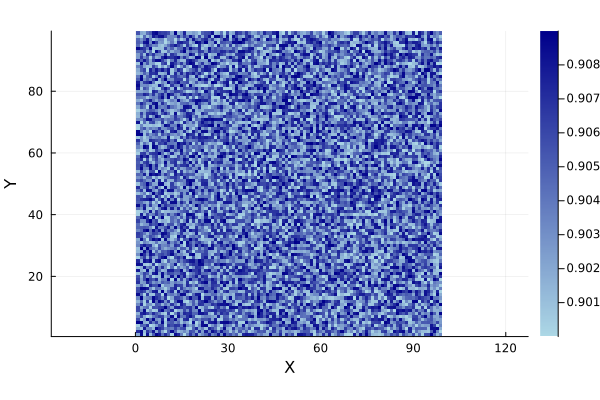

In [9]:

function RHS!(dx, x, p, t)
    Du, Dv, A, k, a, b = p
    u = @view x[:, 1]
    v = @view x[:, 2]
    c = u .* u .* v
    dx[:, 1] .= -Du * A * u .+ k * (a .- u .+ c)
    dx[:, 2] .= -Dv * A * v .+ k * (b .- c)
end



tspan = (0.0, T)
u0 = compute_u0(a, b, Nx, Ny)
v0 = compute_v0(a, b, Nx, Ny)
A = FDLaplacian2D(Nx, Ny, dx, dy)
u = [u0 v0]
p = (; Du, Dv, A, k, a, b)

 
prob = ODEProblem(RHS!, u, tspan, p)

# sol = solve(prob, Euler(), dt=T/50000, save_everystep = false)
@code_warntype solve(prob, save_everystep = false)
sol = solve(prob, Tsit5(), dt = T/50, save_everystep = false)
@btime solve(prob, Tsit5(), dt = T/50, save_everystep = false)

uK = sol.u[end][:, 1]
vK = sol.u[end][:, 2]
u_res = reshape(uK, Nx-1, Ny-1)
v_res = reshape(vK, Nx-1, Ny-1)

heatmap(u_res, c=:blues, aspect_ratio=:equal, xlabel="X", ylabel="Y")